###Imports

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import sentiment
#from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
 #!tar -xvf '/content/drive/MyDrive/Dataset/aclImdb_v1.tar.gz'

In [2]:
def read_imdb(data_dir):
    data = []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir,label)
        for file in os.listdir(folder_name):
          #print(file)
          with open(os.path.join(folder_name, file), 'rb') as f:
            #print(f.name.split('/')[5].split('.')[0])
            fname = f.name.split('/')[5].split('.')[0].split('_')
            review = f.read().decode('utf-8').replace('\n', '')
            sentiment = 1 if label == 'pos' else -1

            data_tuple = (fname[0],fname[1],sentiment,review)
            data.append(data_tuple)
            #break
    return data 

def generate_csv(data,filename):
  np.savetxt(filename, [p for p in zip(data[0], data[1], data[2],data[3])], delimiter='|', fmt='%s')

TRAIN_PATH='/content/aclImdb/train/'
TEST_PATH='/content/aclImdb/test/'

train = read_imdb(TRAIN_PATH)
test = read_imdb(TEST_PATH)

###Data Analysis

In [3]:
df_train = pd.DataFrame(train, columns =['id','rating','label','review'])
df_test = pd.DataFrame(test, columns =['id','rating','label','review'])

df_train.head(3)

,id,rating,label,review
0,3070,7,1,"""Panic"" is a captivating, blurred-genre film a..."
1,4953,8,1,"Running only seventy-two minutes, this small, ..."
2,3772,10,1,Bill and Ted's bogus journey is possible the m...


####Train Data

In [8]:
print("Train Shape", df_train.shape)

Train Shape (25000, 4)


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   rating  25000 non-null  object
 2   label   25000 non-null  int64 
 3   review  25000 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.4+ KB


In [10]:
df_train.isna().sum()

id        0
rating    0
label     0
review    0
dtype: int64

Distribution by: label
-1    12500
 1    12500
Name: label, dtype: int64


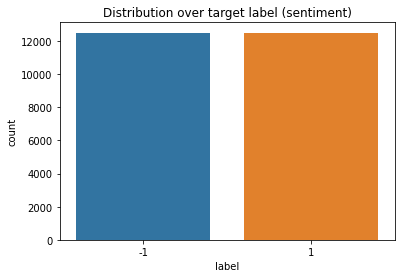

In [11]:
dist = df_train.groupby(['label'])['label'].count() 
print("Distribution by:", dist)
sns.countplot(df_train['label'], data=df_train)
plt.title('Distribution over target label (sentiment)')
plt.show()

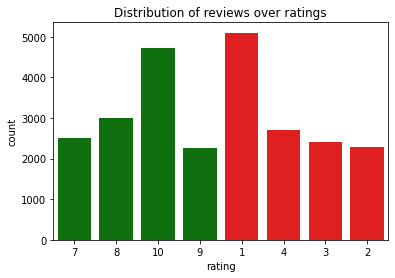

In [12]:
custom_palette = {}
for r in set(df_train['rating'].unique()):
    if int(r) < 5:
        custom_palette[r] = 'r'
    else:
        custom_palette[r] = 'g'


sns.countplot(df_train['rating'], data=df_train, palette=custom_palette)
plt.title("Distribution of reviews over ratings")
plt.show()

In [13]:
dist = df_train.groupby(['label','rating'])['label'].count()
print("Distribution by:", dist) 

Distribution by: label  rating
-1     1         5100
       2         2284
       3         2420
       4         2696
 1     10        4732
       7         2496
       8         3009
       9         2263
Name: label, dtype: int64




*   The train data size is 25000.

*   It contains equal number of positive and negative reviews i.e 12500 each.

*   The ratings in range [7-10] denote positive reviews.

*   The ratings in range [1-4] denote negative reviews.



In [14]:
def calc_len(x):
  #print(len(x))
  return len(x)

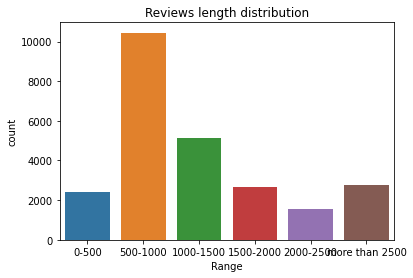

In [15]:
df_train['wordcount'] = df_train['review'].apply(calc_len)

bins = [-1, 500, 1000, 1500, 2000, 2500, np.inf]
labels=['0-500','500-1000','1000-1500', '1500-2000', '2000-2500', 'more than 2500']
df_train['bins'] = pd.cut(df_train['wordcount'], bins=bins, labels=labels)

sns.countplot(df_train['bins'], data=df_train)
plt.title("Reviews length distribution")
plt.xlabel("Range")
plt.show()

bins            label
0-500           -1       1063
                 1       1359
500-1000        -1       5396
                 1       5049
1000-1500       -1       2672
                 1       2478
1500-2000       -1       1327
                 1       1334
2000-2500       -1        777
                 1        783
more than 2500  -1       1265
                 1       1497
dtype: int64


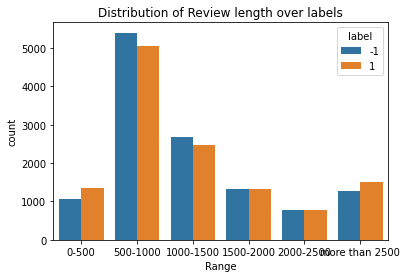

In [16]:
df_wc=df_train.groupby(['bins','label']).size()
print (df_wc)
sns.countplot(x='bins', hue='label', data=df_train)
plt.title("Distribution of Review length over labels")
plt.xlabel("Range")
plt.show()

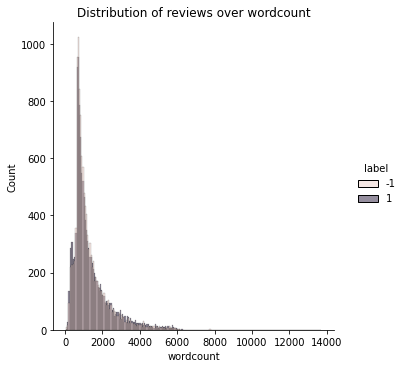

In [17]:
sns.displot(x= 'wordcount', hue = 'label', data = df_train)
plt.title('Distribution of reviews over wordcount')
plt.show()

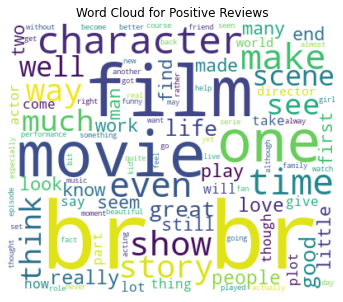

In [18]:
wcp = WordCloud(width=400, height=330, max_words=100, background_color='white').generate(" ".join(df_train[df_train.label == 1].review))

plt.figure(figsize=(15,5))
plt.imshow(wcp, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()

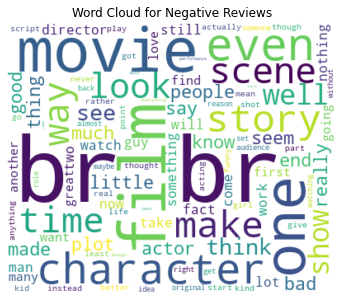

In [19]:
wcn = WordCloud(width=400, height=330, max_words=100, background_color='white').generate(" ".join(df_train[df_train.label == -1].review))

plt.figure(figsize=(15,5))
plt.imshow(wcn, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()

In [20]:
pos_wf = list(wcp.words_.keys())
neg_wf = list(wcn.words_.keys())
print("Positive Reviews : ",pos_wf)
print("Negative Reviews : ",neg_wf)
common = [x for x in pos_wf if x in neg_wf]
print("Common : ", common)

Positive Reviews :  ['br br', 'film', 'movie', 'one', 'character', 'time', 'make', 'even', 'show', 'story', 'way', 'see', 'much', 'think', 'scene', 'well', 'great', 'good', 'life', 'really', 'people', 'love', 'work', 'little', 'still', 'look', 'know', 'seem', 'play', 'end', 'made', 'many', 'find', 'first', 'two', 'man', 'thing', 'give', 'say', 'now', 'will', 'take', 'lot', 'come', 'part', 'actor', 'plot', 'though', 'director', 'world', 'performance', 'role', 'watch', 'may', 'alway', 'serie', 'real', 'fact', 'something', 'seen', 'never', 'feel', 'new', 'family', 'live', 'set', 'become', 'actually', 'want', 'another', 'although', 'especially', 'go', 'right', 'yet', 'quite', 'got', 'going', 'rather', 'back', 'thought', 'day', 'girl', 'course', 'funny', 'bit', 'better', 'moment', 'played', 'almost', 'fan', 'music', 'get', 'friend', 'beautiful', 'kid', 'without', 'episode', 'help', 'acting']
Negative Reviews :  ['br br', 'film', 'movie', 'one', 'even', 'character', 'story', 'make', 'scene',

####Test Data

In [21]:
print("Test Shape", df_test.shape)

Test Shape (25000, 4)


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   rating  25000 non-null  object
 2   label   25000 non-null  int64 
 3   review  25000 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.4+ KB


In [23]:
df_test.isna().sum()

id        0
rating    0
label     0
review    0
dtype: int64

Distribution by: label
-1    12500
 1    12500
Name: label, dtype: int64


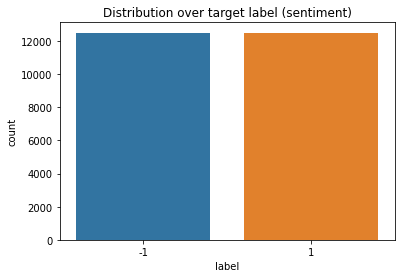

In [24]:
dist = df_test.groupby(['label'])['label'].count() 
print("Distribution by:", dist)
sns.countplot(df_test['label'], data=df_test)
plt.title('Distribution over target label (sentiment)')
plt.show()

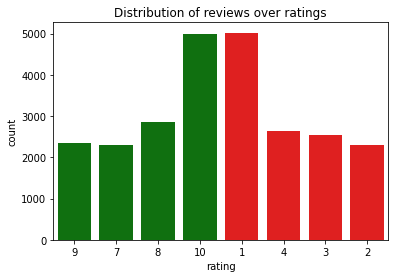

In [25]:
custom_palette = {}
for r in set(df_test['rating'].unique()):
    if int(r) < 5:
        custom_palette[r] = 'r'
    else:
        custom_palette[r] = 'g'


sns.countplot(df_test['rating'], data=df_test, palette=custom_palette)
plt.title("Distribution of reviews over ratings")
plt.show()

In [26]:
dist = df_test.groupby(['label','rating'])['label'].count()
print("Distribution by:", dist) 

Distribution by: label  rating
-1     1         5022
       2         2302
       3         2541
       4         2635
 1     10        4999
       7         2307
       8         2850
       9         2344
Name: label, dtype: int64




*   The test data size is 25000.

*   It contains equal number of positive and negative reviews i.e 12500 each.

*   The ratings in range [7-10] denote positive reviews.

*   The ratings in range [1-4] denote negative reviews.



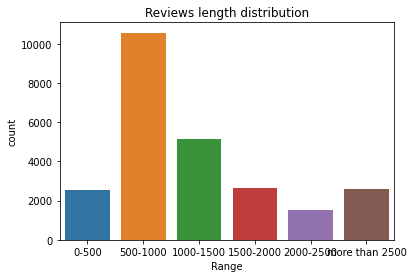

In [27]:
df_test['wordcount'] = df_test['review'].apply(calc_len)

bins = [-1, 500, 1000, 1500, 2000, 2500, np.inf]
labels=['0-500','500-1000','1000-1500', '1500-2000', '2000-2500', 'more than 2500']
df_test['bins'] = pd.cut(df_test['wordcount'], bins=bins, labels=labels)

sns.countplot(df_test['bins'], data=df_test)
plt.title("Reviews length distribution")
plt.xlabel("Range")
plt.show()

bins            label
0-500           -1       1177
                 1       1384
500-1000        -1       5338
                 1       5233
1000-1500       -1       2618
                 1       2529
1500-2000       -1       1374
                 1       1256
2000-2500       -1        792
                 1        726
more than 2500  -1       1201
                 1       1372
dtype: int64


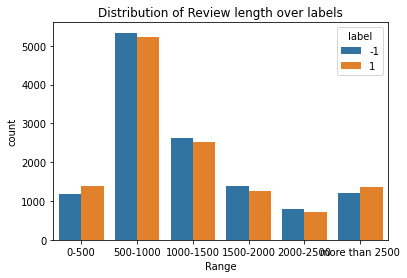

In [28]:
df_wc=df_test.groupby(['bins','label']).size()
print (df_wc)
sns.countplot(x='bins', hue='label', data=df_test)
plt.title("Distribution of Review length over labels")
plt.xlabel("Range")
plt.show()

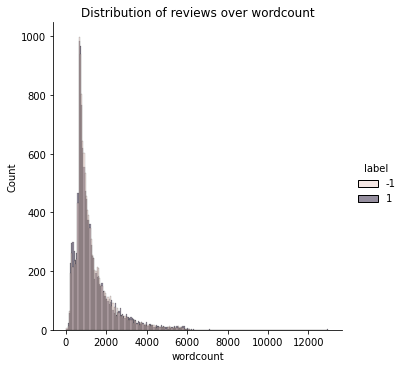

In [29]:
sns.displot(x= 'wordcount', hue = 'label', data = df_test)
plt.title('Distribution of reviews over wordcount')
plt.show()

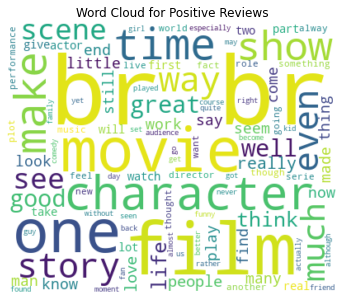

In [30]:
wcp = WordCloud(width=400, height=330, max_words=100, background_color='white').generate(" ".join(df_test[df_test.label == 1].review))

plt.figure(figsize=(15,5))
plt.imshow(wcp, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()

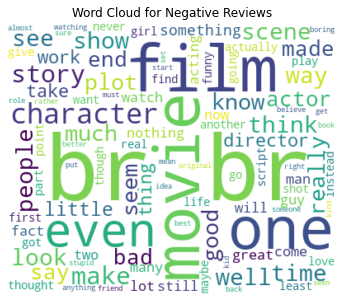

In [31]:
wcn = WordCloud(width=400, height=330, max_words=100, background_color='white').generate(" ".join(df_test[df_test.label == -1].review))

plt.figure(figsize=(15,5))
plt.imshow(wcn, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()

In [32]:
pos_wf = list(wcp.words_.keys())
neg_wf = list(wcn.words_.keys())
print("Positive Reviews : ",pos_wf)
print("Negative Reviews : ",neg_wf)
common = [x for x in pos_wf if x in neg_wf]
print("Common : ", common)

Positive Reviews :  ['br br', 'film', 'movie', 'one', 'character', 'time', 'make', 'show', 'story', 'way', 'even', 'much', 'scene', 'see', 'great', 'well', 'good', 'think', 'life', 'really', 'people', 'love', 'know', 'look', 'many', 'end', 'little', 'work', 'still', 'play', 'say', 'man', 'thing', 'now', 'seem', 'made', 'find', 'come', 'give', 'first', 'part', 'watch', 'two', 'lot', 'take', 'will', 'actor', 'real', 'something', 'plot', 'though', 'role', 'world', 'music', 'alway', 'performance', 'director', 'serie', 'another', 'fact', 'live', 'want', 'feel', 'new', 'thought', 'going', 'especially', 'become', 'set', 'never', 'funny', 'seen', 'go', 'yet', 'although', 'may', 'better', 'actually', 'back', 'day', 'got', 'played', 'friend', 'comedy', 'us', 'guy', 'fan', 'course', 'right', 'quite', 'kid', 'family', 'without', 'almost', 'moment', 'girl', 'get', 'found', 'audience', 'rather']
Negative Reviews :  ['br br', 'film', 'movie', 'one', 'even', 'character', 'story', 'make', 'show', 'thin

### Data Cleaning

* Words like [movie, film, character, one, story, time, really, make ] are frequent in both the sentiments, thus they do not help in classification. 
* We will ignore these words during data cleaning.

In [4]:
IGNORE_WORDS = ['br br', 'film', 'movie', 'one', 'character', 'time', 'make', 'even', 'show', 'story', 'way', 'see', 'much', 'think', 'scene', 'well', 'great', 'good', 'life', 'really', 'people', 'love', 'work', 'little', 'still', 'look', 'know', 'seem', 'play', 'end', 'made', 'many', 'find', 'first', 'two', 'man', 'thing', 'give', 'say', 'now', 'will', 'take', 'lot', 'come', 'part', 'actor', 'plot', 'though', 'director', 'performance', 'role', 'watch', 'real', 'fact', 'something', 'never', 'new', 'set', 'actually', 'want', 'another', 'go', 'right', 'got', 'going', 'rather', 'back', 'thought', 'girl', 'funny', 'better', 'almost', 'get', 'kid', 'without', 'acting']
def clean_data(review):
    #print("Org : " , review)

    #HTML tag
    raw_text=BeautifulSoup(review, 'html').get_text()
    #print("Html : ",raw_text)

    #urls
    raw_text = re.sub(r"(www|http:|https:)+[\S]+[\w]", "", raw_text)
    #print("Links : ",raw_text)
    
    #non English character
    letters = re.sub('[^a-zA-Z]', ' ', raw_text)
    #print("Non English : ",letters)

    #lowercase
    tokens = letters.lower().split() 

    #filter ignore_words
    #tokens = [token for token in tokens if token not in IGNORE_WORDS] 
    #print(tokens)

    #stopwords and stemming
    stopwords = nltk.corpus.stopwords.words('english')
    wn = nltk.WordNetLemmatizer()
    words = [wn.lemmatize(w) for w in tokens if w not in stopwords ]
    
    #ignore_words
    IGNORE_WORDS_LEM = [wn.lemmatize(w).lower() for w in IGNORE_WORDS]
    words = [w for w in words if w not in IGNORE_WORDS_LEM]

    #ps = nltk.PorterStemmer()
    #words = [ps.stem(w) for w in tokens if w not in stopwords]
    
    #print("Tokens : ",words)
    return words

In [7]:
clean_data("film! this is test aaa <br> https://urls.com, is good with <b>technology</b>! Tests failed? See movies one two")

['test', 'aaa', 'technology', 'test', 'failed']

In [6]:
df_Xtr =  df_train['review'].apply(clean_data)
df_Ytr = df_train['label']
print(df_Xtr.shape, df_Ytr.shape)

(25000,) (25000,)


In [5]:
df_Xte =  df_test['review'].apply(clean_data)
df_Yte = df_test['label']
print(df_Xte.shape, df_Yte.shape)

(25000,) (25000,)


In [6]:
def generate_vocab(data): 
  vocab = set()
  for clean_x in data : #cleaned_data
    for word in clean_x :
      #print(word)
      vocab.add(word)
      #break
  return sorted(vocab)

In [17]:
vocab1 = generate_vocab(df_Xtr)
#print("Vocab : ",vocab1)
print("Vocab Length of Train set : ", len(vocab1))

Vocab Length of Train set :  66314


In [7]:
vocab2 = generate_vocab(df_Xte)
print("Vocab Length of Test set : ", len(vocab2))

Vocab Length of Test set :  65534


###Feature Extraction

####BagOfWords

#####Train set

In [7]:
bow_vectorizer = CountVectorizer(analyzer = "word", min_df=3, tokenizer = lambda x: x, lowercase=False,  preprocessor = None, stop_words = None)
train_features = bow_vectorizer.fit_transform(df_Xtr).toarray()
dfbow = pd.DataFrame(data=train_features,columns = bow_vectorizer.get_feature_names())
print(dfbow.shape)
dfbow.head()

(25000, 31179)


,aa,aaa,aaargh,aag,aage,aames,aamir,aankhen,aapke,aardman,...,zorro,zp,zsigmond,zu,zucco,zucker,zuckerman,zulu,zuniga,zwick
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
features_count =  np.sum(train_features,axis=0)
features_count = pd.DataFrame(dict(features = bow_vectorizer.get_feature_names(), counts = features_count))
features_count.sort_values('counts', ascending=False)[0:20]

,features,counts
16095,like,20740
30802,would,12436
1892,bad,9301
736,also,9156
5963,could,7922
30955,year,6878
24434,seen,6679
2518,best,6420
9384,ever,5995
30704,woman,4624


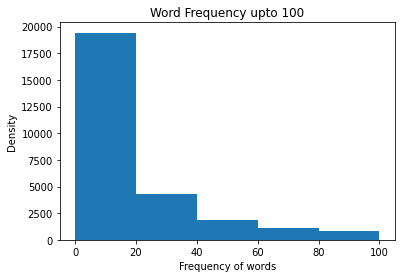

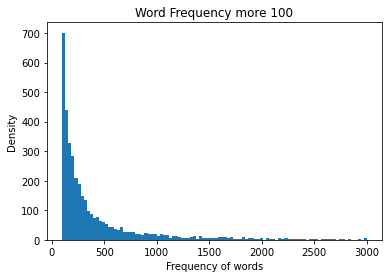

In [15]:
plt.title("Word Frequency upto 100")
plt.hist(features_count.counts, bins=5, range=(0,100))
plt.xlabel("Frequency of words")
plt.ylabel("Density")
plt.show()

plt.title("Word Frequency more 100")
plt.hist(features_count.counts, bins=100, range=(100,3000))
plt.xlabel("Frequency of words")
plt.ylabel("Density")
plt.show()

* Since the vocab of Train set is too huge (66314), we can reduce the number of features my limiting the threshold on the frequency of the words.
* Words with low frequency are high in number, so such words can be filtered out using min_df to decrease the feature size.
* We use min_dif = 10 and reduce the feature size to 16249.

In [17]:
bow_vectorizer = CountVectorizer(analyzer = "word", min_df=10, tokenizer = lambda x: x, lowercase=False,  preprocessor = None, stop_words = None)
train_features = bow_vectorizer.fit_transform(df_Xtr).toarray()
dfbow = pd.DataFrame(data=train_features,columns = bow_vectorizer.get_feature_names())
print(dfbow.shape)
dfbow.head()

(25000, 16249)


,aag,aames,aaron,ab,abandon,abandoned,abandoning,abandonment,abbas,abbey,...,zombi,zombie,zone,zoo,zoom,zorro,zu,zucker,zulu,zuniga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
print("Train Features in bag of words : ",len(bow_vectorizer.vocabulary_))

Train Features in bag of words :  16249


#####Test set

In [8]:
bow_vectorizer = CountVectorizer(analyzer = "word", min_df=3, tokenizer = lambda x: x, lowercase=False,  preprocessor = None, stop_words = None)
test_features = bow_vectorizer.fit_transform(df_Xte).toarray()
dfbow = pd.DataFrame(data=test_features,columns = bow_vectorizer.get_feature_names())
print(dfbow.shape)
dfbow.head()

(25000, 30705)


,aa,aaa,aaliyah,aamir,aardman,aaron,ab,aback,abandon,abandoned,...,zozo,zu,zucco,zucker,zudina,zula,zulu,zurer,zwart,zwick
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
features_count =  np.sum(train_features,axis=0)
features_count = pd.DataFrame(dict(features = bow_vectorizer.get_feature_names(), counts = features_count))
features_count.sort_values('counts', ascending=False)[0:20]

,features,counts
15823,like,20376
30342,would,12163
1881,bad,9159
740,also,8816
5886,could,7641
24007,seen,6693
30495,year,6369
2497,best,6200
9237,ever,6025
11916,guy,4916


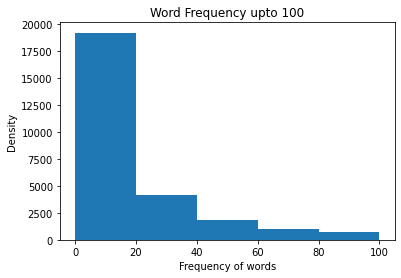

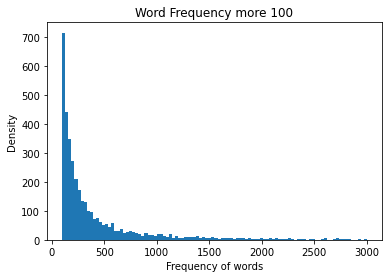

In [10]:
plt.title("Word Frequency upto 100")
plt.hist(features_count.counts, bins=5, range=(0,100))
plt.xlabel("Frequency of words")
plt.ylabel("Density")
plt.show()

plt.title("Word Frequency more 100")
plt.hist(features_count.counts, bins=100, range=(100,3000))
plt.xlabel("Frequency of words")
plt.ylabel("Density")
plt.show()

* Since the vocab of Test set is too huge (65534), we can reduce the number of features my limiting the threshold on the frequency of the words.
* Words with low frequency are high in number, so such words can be filtered out using min_df to decrease the feature size.
* We use min_dif = 10 and reduce the feature size to 15958.

In [11]:
bow_vectorizer = CountVectorizer(analyzer = "word", min_df=10, tokenizer = lambda x: x, lowercase=False,  preprocessor = None, stop_words = None)
test_features = bow_vectorizer.fit_transform(df_Xte).toarray()
dfbow = pd.DataFrame(data=test_features,columns = bow_vectorizer.get_feature_names())
print(dfbow.shape)
dfbow.head()

(25000, 15958)


,aaliyah,aamir,aardman,aaron,ab,aback,abandon,abandoned,abandonment,abba,...,zip,zoe,zoey,zombie,zone,zoo,zoom,zooming,zucco,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [12]:
print("Test Features in bag of words : ",len(bow_vectorizer.vocabulary_))

Test Features in bag of words :  15958


####  TF-IDF

#####Train set

In [19]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, use_idf=True) #stop_words='english' , smooth_idf=True(default)
tfidf = tfidf_vectorizer.fit_transform(df_Xtr)

#print("Vocab : \n ",tfidf_vectorizer.vocabulary_) #mapping{word: feature index}
print("IDF Vector : \n ",tfidf_vectorizer.idf_)

IDF Vector : 
  [ 9.33491163  9.04722956 10.43352392 ... 10.43352392 10.43352392
 10.43352392]


In [20]:
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights']).head(20)

,idf_weights
like,1.745070
would,2.123109
also,2.353596
could,2.432001
bad,2.443116
seen,2.545565
year,2.594392
best,2.628661
ever,2.649259
watching,2.875529


These are only IDF values. Inverse Document Frequency Score is inversely proportional to the usage frequency of the words. Not so important words which may not tell the context has lower IDF since they appear in every sentences.

In [22]:
idx = 5
print("\n Review tokens : ",df_Xtr.loc[idx])
df_tfidf = pd.DataFrame(tfidf[idx].T.todense(), index=tfidf_vectorizer.get_feature_names_out (), columns=["tfidf"])
df_tfidf.sort_values(by=["tfidf"],ascending=False).head(20)


 Review tokens :  ['short', 'trailer', 'basically', 'superman', 'batman', 'working', 'together', 'forming', 'uneasy', 'alliance', 'obviously', 'vastly', 'differing', 'view', 'deal', 'crime', 'constitutes', 'punishment', 'fun', 'iconic', 'try', 'along', 'int', 'storyline', 'terrific', 'everyone', 'cast', 'playing', 'superman', 'batman', 'suited', 'filmmaker', 'batman', 'dead', 'grayson', 'also', 'short', 'three', 'probably', 'liked', 'least', 'done', 'world', 'finest']


,tfidf
batman,0.452124
superman,0.321653
differing,0.225778
int,0.222839
constitutes,0.204192
forming,0.199424
short,0.186615
grayson,0.184396
uneasy,0.184396
alliance,0.183235


Here, we see TFIDF values for 5th document of our trainset. We can explore other values by updating the value of idx.

In [24]:
print("Number of Train features in TFIDF : ",len(tfidf_vectorizer.vocabulary_))

Number of Train features in TFIDF :  66314


#####Test set

In [13]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, use_idf=True) #stop_words='english' , smooth_idf=True(default)
tfidf = tfidf_vectorizer.fit_transform(df_Xte)

#print("Vocab : \n ",tfidf_vectorizer.vocabulary_) #mapping{word: feature index}
print("IDF Vector : \n ",tfidf_vectorizer.idf_)

IDF Vector : 
  [ 8.92944653  9.18076095 10.43352392 ... 10.43352392 10.43352392
 10.43352392]


In [14]:
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights']).head(20)

,idf_weights
like,1.762409
would,2.133492
also,2.379637
bad,2.446849
could,2.466764
seen,2.540138
ever,2.635001
year,2.648635
best,2.655941
watching,2.889986


These are only IDF values. Inverse Document Frequency Score is inversely proportional to the usage frequency of the words. Not so important words which may not tell the context has lower IDF since they appear in every sentences.

In [15]:
idx = 5
print("\n Review tokens : ",df_Xte.loc[idx])
df_tfidf = pd.DataFrame(tfidf[idx].T.todense(), index=tfidf_vectorizer.get_feature_names_out (), columns=["tfidf"])
df_tfidf.sort_values(by=["tfidf"],ascending=False).head(20)


 Review tokens :  ['carla', 'gugino', 'yay', 'crappy', 'ending', 'boo', 'jaded', 'highly', 'erotic', 'beautiful', 'woman', 'arrives', 'town', 'trying', 'escape', 'past', 'while', 'meet', 'lesbian', 'couple', 'drink', 'decide', 'fun', 'bit', 'far', 'rape', 'while', 'second', 'hold', 'discovered', 'beach', 'incident', 'happens', 'next', 'day', 'taken', 'hospital', 'spend', 'rest', 'watching', 'attempting', 'bring', 'learn', 'info', 'bit', 'past', 'co', 'writer', 'caryn', 'krooth', 'excellent', 'job', 'considering', 'uber', 'low', 'budget', 'hand', 'held', 'sometimes', 'like', 'mm', 'fit', 'since', 'demand', 'harsh', 'okay', 'job', 'given', 'anything', 'complain', 'standout', 'feature', 'course', 'carla', 'gugino', 'bares', 'nude', 'sin', 'city', 'christopher', 'mcdonald', 'also', 'kinda', 'pointless', 'fun', 'pay', 'attention', 'music', 'since', 'draw', 'attention', 'job', 'done', 'r', 'rated', 'reason', 'sexual', 'graphic', 'essentially', 'border', 'soft', 'core', 'sex', 'necessary', '

,tfidf
while,0.369753
caryn,0.256469
krooth,0.256469
mcdonald,0.201130
gugino,0.198669
carla,0.197526
pointless,0.186083
jaded,0.168726
erotic,0.150177
job,0.130765


Here, we see TFIDF values for 5th document of our trainset. We can explore other values by updating the value of idx.

In [16]:
print("Number of Test features in TFIDF : ",len(tfidf_vectorizer.vocabulary_))

Number of Test features in TFIDF :  65534
